In [1]:
import scipy as sp
import pylab as plt
from scipy.integrate import odeint

In [2]:
# full Hodgkin-Huxley model
# membrane capacitance (uF/cm^2)
C_m  =   1.0 
    
#constants for Na gate
g_Na = 120.0
V_Na =  -115.0

#constants for K gate
g_K  =  36.0
V_K  = 12.0

#constants for leak gate
g_L  =   0.3
V_L  = -10.613

#time we'll be integrating over. We'll be operating over 500 ms with a step size of 0.01.
t = sp.arange(0.0, 500.0, 0.01)

#functions for computing current through membranes
def i_Na(V, m, h):
    return g_Na * m**3 * h * (V - V_Na)

def i_K(V, n):
    return g_K  * n**4 * (V - V_K)

def i_L(V):
    return g_L * (V - V_L)

#functions for rate constants of ion channels
def alpha_m(V):
    return 0.1*(V+25.0)/(sp.exp((V+25.0)/10.0)-1)

def beta_m(V):
    return 4.0*sp.exp(V / 18.0)

def alpha_h(V):
    return 0.07*sp.exp(V / 20.0)

def beta_h(V):
    return 1.0/(1.0 + sp.exp((V+30.0) / 10.0))

def alpha_n(V):
    return 0.01*(V+10.0)/(sp.exp((V+10.0) / 10.0)-1)

def beta_n(V):
    return 0.125*sp.exp(V / 80.0)

#input injection function
def inject_I(t):
    # tuples dictating fluctuations in external current upon injection in given time frames (basially where spikes will occur) =>
    #step1 = {'t': 0, 'V': 10} #step up 10 uA/cm^2 @ t=0
    step2 = {'t': 100, 'V': 20} #step up 20 uA/cm^2 @ t=100
    step3 = {'t': 200, 'V': -20} #step down 20 uA/cm^2 @t=200
    step4 = {'t': 300, 'V': 100} #step up 100 uA/cm^2 @ t=300
    step5 = {'t': 400, 'V': -100} #step down 100 uA/cm^2 @ t=400
    
    return step2['V']*(t>step2['t']) + step3['V']*(t>step3['t']) + step4['V']*(t>step4['t']) + step5['V']*(t>step5['t'])
    #step1['V']*(t>step1['t']) + 
#computes derivatives of activation variables
def compute_derivs(X, t):
    V, m, h, n = X
    dVdt = (inject_I(t) - i_Na(V, m, h) - i_K(V, n) - i_L(V)) / C_m
    dmdt = alpha_m(V)*(1.0-m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1.0-h) - beta_h(V)*h
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return dVdt, dmdt, dhdt, dndt

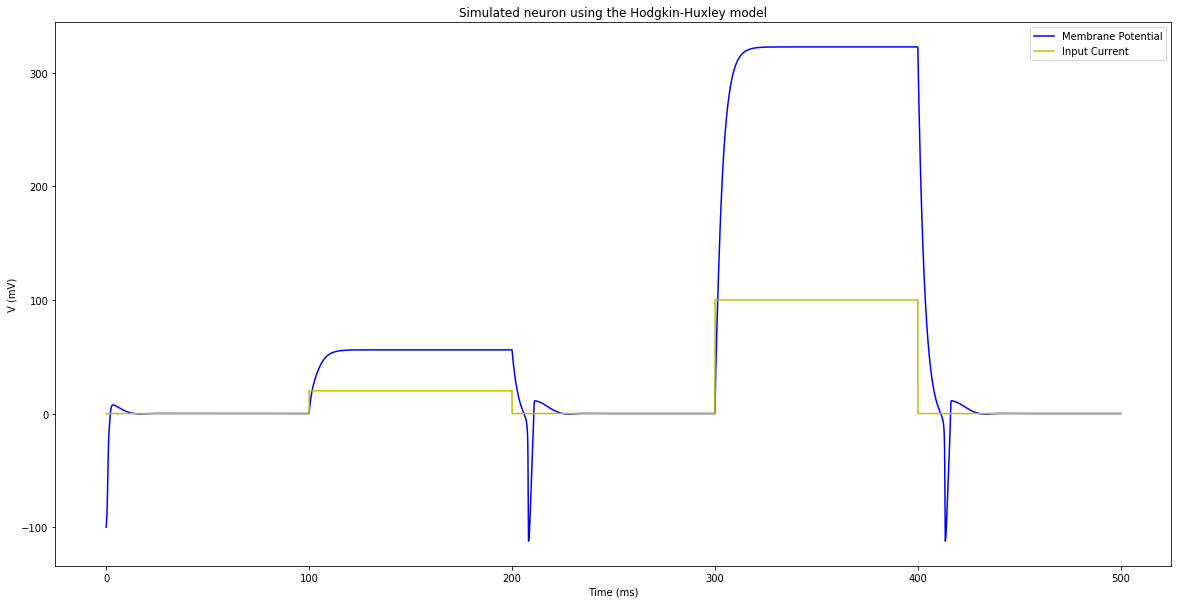

In [3]:
#plotting Hodgkin-Huxley model simulation
X = odeint(compute_derivs, [-100, 0, 0, 0], t)
V = X[:,0]
#m = X[:,1]
#h = X[:,2]
#n = X[:,3]

plt.figure(figsize = (20,10))
plt.title('Simulated neuron using the Hodgkin-Huxley model')
plt.plot(t, V, 'b', label = 'Membrane Potential' )
plt.plot(t, [inject_I(x) for x in t], 'y', label = 'Input Current')
plt.ylabel('V (mV)')
plt.xlabel('Time (ms)')
plt.legend(loc='upper right')
